In [1]:
import os
import re
import yaml
import glob

import numpy as np
import pandas as pd

import operator
from math import ceil

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import binom
from scipy.stats import entropy

import napari

from utils.utility_functions import single_channel_pyramid

In [2]:
# I/O
sample = 'CRC-097'
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), f'input/{sample}_hema_eosin.ome.tif')

# get list of markers that were excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# the parquet file at the path below is being read because "main.csv" 
# uses trimmed marker channel names as column headers that differ from the raw channel names used 
# in the markers.csv file used to index channels in the OME-TIFF image.
for_channels = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# isolate antibodies of interest
abx_channels = [
    i for i in for_channels.columns if 'nucleiRingMask' in i if 'Hoechst' not in i
    if i not in markers_to_exclude
]

# read single-cell data from VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# optional: filter VAE30 clusters according to size
filt = main.groupby('VAE30').size()
filt = filt.index[filt > 0]
filt = filt.tolist()

df = main[main['VAE30'].isin(filt)]

count_headers = [f'VAE9_{i}' for i in sorted(df['VAE9_VIG7'].unique())]

out = os.path.join(os.getcwd(), 'output/cluster_entropy')
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
window_size = 46
half_window_size = window_size / 2
if not os.path.exists(os.path.join(out, 'counts_minus_ref.csv')):

    counts = pd.DataFrame(columns=['VAE30', 'VAE9'] + count_headers)

    for vae_cluster, group in df.groupby('VAE30'):
        print(vae_cluster)
        for i in group.iterrows():
            dta = pd.DataFrame(columns=['VAE30', 'VAE9'] + count_headers)
            dta.loc[0, 'VAE30'] = vae_cluster
            dta.loc[0, 'VAE9'] = int(i[1]['VAE9_VIG7'])
            dta.loc[0, count_headers] = 0

            # isolate cells within 46x46pixel area (30x30um)
            x = i[1]['X_centroid']
            y = i[1]['Y_centroid']
            patch = (
                df[(df['Y_centroid'].between(y - half_window_size, y + half_window_size)) &
                    (df['X_centroid'].between(x - half_window_size, x + half_window_size))].copy()
            )

            cnts = patch.groupby('VAE9_VIG7').size()

            for j in cnts.index:
                dta.loc[0, f'VAE9_{j}'] = cnts[j]
            counts = pd.concat([counts, dta], axis=0)

    counts.reset_index(drop=True, inplace=True)
    counts.to_csv(os.path.join(out, 'counts.csv'), index=False)

    # subtract reference cells from counts table
    for idx, dta in counts.iterrows():
        if idx % 10000 == 0:
            print(idx)
        current = counts.loc[idx, f"VAE9_{dta['VAE9']}"]
        counts.loc[idx, f"VAE9_{dta['VAE9']}"] = (current - 1)
    counts.to_csv(os.path.join(out, 'counts_minus_ref.csv'), index=False)

else:
    # Read reference cell substracted counts table
    counts = pd.read_csv(os.path.join(out, 'counts_minus_ref.csv'))

In [4]:
# compute VAE30 cluster enrichment pvals

# scipy.stats.binom.cdf(k, n, p)

# k: float or array_like of floats representing random variable
# (i.e. how many cells of a particular VAE9 cluster are in a given VAE30 cluster's image patches)

# n: number of trials, must be >= 0
# (i.e. how many cells are in a given VAE30 cluster)

# p: probability of success in each trial, must be in range [0, 1]
# (i.e. what is the frequency of a given VAE9 cluster in the dataset)

counts = counts[counts['VAE30'].isin(df['VAE30'].unique())]

p = counts.groupby('VAE9').size() / len(counts)
p.index = [f'VAE9_{i}' for i in p.index]

n = counts.groupby(['VAE30']).size()

k = counts.loc[:, counts.columns != 'VAE9'].groupby(['VAE30']).sum()

pvals = k.copy().astype('float')
for v30_cluster in k.index:
    for v9_cluster in k.columns:

        # plot CDF
        if (v30_cluster == 1) and (v9_cluster == 'VAE9_0'):
            x = np.arange(0, n[v30_cluster], 0.01)
            y = binom.cdf(k=x, n=n[v30_cluster], p=p[v9_cluster])
            plt.plot(x, y, c='k')
            plt.tight_layout()
            plt.savefig(os.path.join(out, 'V30_cluster1_cdf.pdf'))
            plt.close('all')

        # compute pval at specific x-coordinate in CDF
        k_example = k.loc[v30_cluster, v9_cluster]
        pval = 1 - binom.cdf(k=k_example, n=n[v30_cluster], p=p[v9_cluster])
        pvals.loc[v30_cluster, v9_cluster] = pval

In [5]:
# compute Shannon entropy for VAE30 clusters with respect to VAE9 cluster heterogeneity
entropies = {}
for vae_cluster, group in df.groupby('VAE30'):
    percents = group.groupby('VAE9_VIG7').size() / len(group)
    percents_pad = percents.reindex(sorted(df['VAE9_VIG7'].unique()), fill_value=0.0)
    entropies[vae_cluster] = entropy(pk=percents_pad, base=2)

# sort entropy scores in ascending order
entropies = dict(sorted(entropies.items(), key=operator.itemgetter(1), reverse=False))

e1 = pd.DataFrame.from_dict(entropies, orient='index')
e1.rename(columns={0: 'entropy'}, inplace=True)

Significant VAE9 cluster enrichments in VAE30 cluster image patches
** row colors represent VAE30 cluster entropy with respect to VAE9 cluster heterogeneity


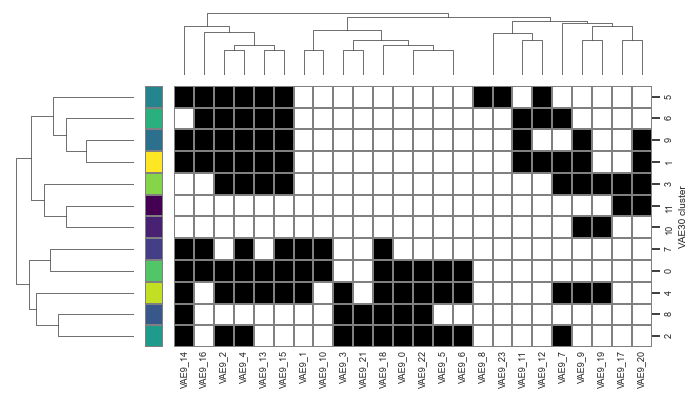

In [6]:
# plot heatmap of CDF pvals
sns.set(font_scale=0.6)
sns.set_style('white')
heatmap = pvals[pvals <= 0.05]
heatmap = heatmap.notnull().astype('int')

res = heatmap.sum(axis=1)
res2 = df.groupby('VAE30').size()
res3 = res2.reindex(res.index)

res4 = pd.DataFrame(data={'VAE9_count': res, 'size': res3})
res4 = res4.sort_values(['VAE9_count', 'size'])
heatmap = heatmap.reindex(res4.index)

# divide viridis colors into to the number of VAE clusters
viridis = plt.get_cmap('viridis', heatmap.shape[0])

# map VAE clusters to their entropy scores
ent = dict(zip(heatmap.index, [entropies[i] for i in heatmap.index]))

# sort the dict by entropy scores
ent = {k: v for k, v in sorted(ent.items(), key=lambda item: item[1])}

# map VAE clusters in heatmap, sorted by entropy, onto viridis colors
lut = dict(zip(ent.keys(), viridis.colors))

# create colors index
row_colors = heatmap.index.map(lut)

g = sns.clustermap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, row_colors=row_colors, figsize=(7, 4)
)

g.cax.set_visible(False)

g.ax_heatmap.set_ylabel('VAE30 cluster')
g.ax_heatmap.get_xaxis().set_tick_params(pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_clustermap.pdf'))
print('Significant VAE9 cluster enrichments in VAE30 cluster image patches')
print('** row colors represent VAE30 cluster entropy with respect to VAE9 cluster heterogeneity')
plt.show()
plt.close('all')

3 out of 12 VAE30 clusters (~25%) with a single VAE9 cluster composition >=80%


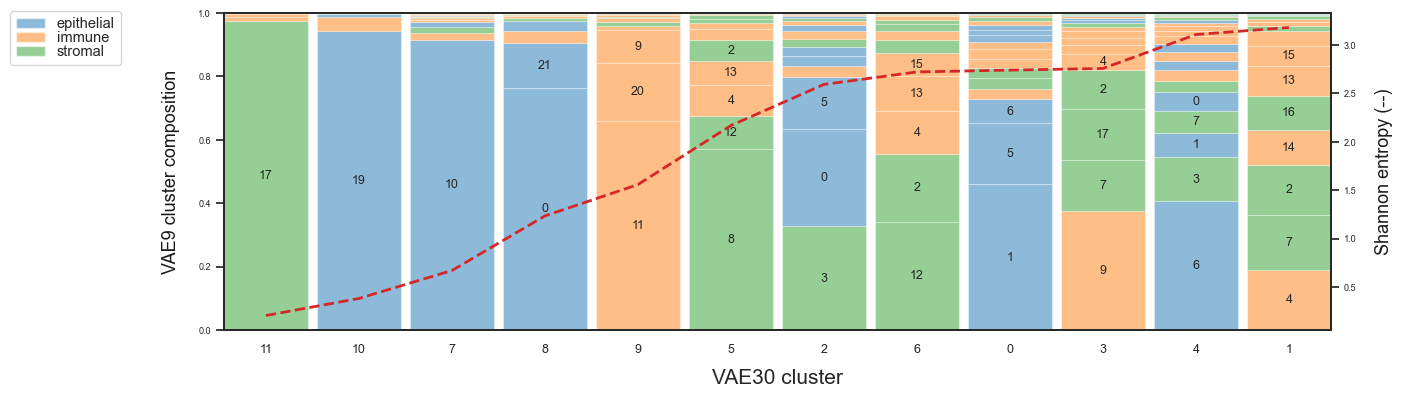

In [18]:
# plot stacked barcharts
bar = df.groupby(['VAE30', 'VAE9_VIG7']).size().unstack().fillna(0)

# normalize VAE9 counts per VAE30 cluster (0-1), sort VAE clusters by entropy
bar = bar.div(bar.sum(axis=1), axis=0)
bar = bar.reindex(entropies.keys())
bar.columns = bar.columns.astype('str')

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()
x = bar.index.astype('str')
indexes = np.argsort(bar.values).T
heights = np.sort(bar.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

# make color dict
epithelial = [0, 1, 3, 5, 6, 10, 19, 21, 22] 
immune = [4, 9, 11, 13, 14, 15, 18, 20]
stromal = [2, 3, 7, 8, 12, 16, 17, 23]

mpp_colors = {}
mpp_colors.update({str(k): v for k, v in zip(epithelial, ['tab:blue'] * len(epithelial))})
mpp_colors.update({str(k): v for k, v in zip(immune, ['tab:orange'] * len(immune))})
mpp_colors.update({str(k): v for k, v in zip(stromal, ['tab:green'] * len(stromal))})

for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):

    mps = np.take(np.array(bar.columns), idxs)
    if btms == 0:
        print(
            f'{len([v for v in vals if v >= 0.8])} out of {len(vals)} VAE30 clusters '
            f'(~{ceil(len([v for v in vals if v >= 0.8])/len(vals)*100)}%) with a single '
            'VAE9 cluster composition >=80%'
        )
    
    # IF YOU DONT WANT TO COLOR THE BARS, USE THIS CODE
    # g = ax1.bar(
    #     x, height=vals, width=0.9, color='w', lw=0.1, ec='k',
    #     bottom=bottoms[btms]
    # )

    # IF YOU WANT TO COLOR THE BARS BY CELL TYPE, USE THIS CODE (MUST UPDATE CLUSTER LISTS FOR COLOR DICT ABOVE) 
    g = ax1.bar(
        x, height=vals, width=0.9, lw=0.5, bottom=bottoms[btms],
        color=[mpp_colors[m] for m in mps], alpha=0.5
    )
    
    patches = [
        Patch(facecolor=color, alpha=0.5, edgecolor=None) for color in ['tab:blue', 'tab:orange', 'tab:green']
    ]
    plt.legend(
        patches, ['epithelial', 'immune', 'stromal'],
        title=None, prop={'size': 10.5},
        labelspacing=0.01, bbox_to_anchor=[-0.2, 1.03], loc='upper left'
    )

    pos = -1
    for i, b in enumerate(g.patches):
        if i % len(bar.index) == 0:
            pos += 1
        xloc = b.get_x() + 0.45
        yloc = b.get_y() + b.get_height()/2
        if b.get_height() > 0.05:
            ax1.annotate(
                mps[i], xy=(xloc, yloc), fontname='Arial',
                va='center', ha='center', size=9
            )

ax1.set_xlabel('VAE30 cluster', size=15, labelpad=10)
ax1.set_ylabel('VAE9 cluster composition', size=13, labelpad=13, c='k')
ax1.tick_params(axis='x', which='major', labelsize=9)
ax1.margins(x=0)

ax2.plot(
    [str(i) for i in entropies.keys()], entropies.values(),
    c='tab:red', lw=2, linestyle='--'
)
ax2.set_ylabel('Shannon entropy (--)', size=13, labelpad=13, c='k')

plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar.pdf'))
plt.show()
plt.close('all')

In [8]:
# calculate the number of V9 clusters needed to account for >=80% of V30 cluster composition 
indices_80_percent = {}
res = bar.T

# iterate over each column
for column in res.columns:
    
    # sort the column values in ascending order
    sorted_column = res[column].sort_values(ascending=False)

    # calculate cumulative sum
    indices_below_80_percent = []
    cumulative_sum = sorted_column.cumsum()
    for e, (idx, val) in enumerate(cumulative_sum.items()):
        if val >= 0.8:
            indices_below_80_percent = list(cumulative_sum.index[:e + 1])
            break
    
    indices_80_percent[column] = indices_below_80_percent

min_length = min(len(lst) for lst in indices_80_percent.values())
max_length = max(len(lst) for lst in indices_80_percent.values())

# find keys with lists of minimum length
shortest_keys = [key for key, lst in indices_80_percent.items() if len(lst) == min_length]

# find keys with lists of maximum length
longest_keys = [key for key, lst in indices_80_percent.items() if len(lst) == max_length]

print(f'Min number of V9 clusters accounting for >=80% of a V30 cluster is {min_length}; those clusters are', shortest_keys)
print(f'Max number of V9 clusters accounting for >=80% of a V30 cluster is {max_length}; those clusters are', longest_keys)

Min number of V9 clusters accounting for >=80% of a V30 cluster is 1; those clusters are [11, 10, 7]
Max number of V9 clusters accounting for >=80% of a V30 cluster is 7; those clusters are [4]


In [9]:
print('Low entropy V30-10 cluster 10 VAE9_VIG7 cell composition')
low_entropy_clus = 10
print()
print((bar.loc[low_entropy_clus] * 100).sort_values(ascending=False))
low_entropy_clusters = (bar.loc[low_entropy_clus] * 100).sort_values(ascending=False)[0:1].index.tolist()
low_entropy_clusters.reverse()
low_entropy_clusters = list(map(int, low_entropy_clusters))

print()

print('High entropy V30-1 VAE9_VIG7 cell composition')
high_entropy_clus = 1
print()
print((bar.loc[high_entropy_clus] * 100).sort_values(ascending=False))
high_entropy_clusters = (bar.loc[high_entropy_clus] * 100).sort_values(ascending=False)[0:7].index.tolist()
high_entropy_clusters.reverse()
high_entropy_clusters = list(map(int, high_entropy_clusters))

Low entropy V30-10 cluster 10 VAE9_VIG7 cell composition

VAE9_VIG7
19    94.347357
9      4.336570
6      0.906149
18     0.129450
2      0.064725
1      0.064725
0      0.021575
3      0.021575
4      0.021575
22     0.021575
7      0.021575
17     0.021575
15     0.021575
16     0.000000
21     0.000000
20     0.000000
12     0.000000
14     0.000000
13     0.000000
11     0.000000
10     0.000000
8      0.000000
5      0.000000
23     0.000000
Name: 10, dtype: float64

High entropy V30-1 VAE9_VIG7 cell composition

VAE9_VIG7
4     19.022395
7     17.343132
2     15.816404
14    10.925605
16    10.707897
13     9.454344
15     6.337100
11     4.772932
12     1.648755
9      1.232753
20     0.991472
8      0.851418
3      0.239895
1      0.191361
17     0.133121
5      0.104001
6      0.067947
10     0.042987
22     0.042987
0      0.041600
18     0.029120
19     0.001387
21     0.001387
23     0.000000
Name: 1, dtype: float64


In [10]:
# add H&E image to Napari viewer as separate RGB channels
for color, channel in zip(['red', 'green', 'blue'], [0, 1, 2]):

    img, min, max = single_channel_pyramid(glob.glob(he_path)[0], channel=channel)

    if channel == 0:
        viewer = napari.view_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
        )
    else:
        viewer.add_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}', contrast_limits=(min, max)
        )

# add H&E image to Napari viewer as a single channel image
# from lazy_ops import DatasetView
# tiff = tifffile.TiffFile(he_path, is_ome=False)
# pyramid = [
#     zarr.open(tiff.series[0].levels[0].aszarr())[i] for i in
#     list(range(len(tiff.series[0].levels)))
#     ]
# pyramid = [DatasetView(i).lazy_transpose([1, 2, 0]) for i in pyramid]
# pyramid = [da.from_zarr(z) for z in pyramid]
#
# viewer = napari.view_image(pyramid, rgb=True, name='H&E')

In [11]:
# Add DNA1 channel to Napari image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True,
    opacity=0.75, name='DNA1', contrast_limits=(min, max)
)

<Image layer 'DNA1' at 0x15a2edb20>

In [12]:
# Add marker channels and apply previously defined contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    
    if ch == 'CD4_488':
        colormap = 'blue' 
        visible = True
    elif ch == 'CD31_647':
        colormap = 'red'
        visible = True
    elif ch == 'CD68_555':
        colormap = 'green'
        visible = True
    elif ch == 'CD8a_660':
        colormap = 'yellow'
        visible = True
    elif ch == 'CD163_488':
        colormap = 'magenta'
        visible = True
    elif ch == 'CD20_488':
        colormap = 'cyan'
        visible = True
    else:
        colormap = 'green'
        visible = False

    viewer.add_image(
        img, rgb=False, blending='additive', colormap=colormap, visible=visible, name=ch,
        contrast_limits=(min, max)
    )
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [13]:
# add centroids of cells for low entropy example cluster
num_colors = len(list(cm.tab10.colors))
num_clusters = len(low_entropy_clusters)
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab10.colors) * palette_multiplier
colors = colors[0:num_clusters]
colors.reverse()

for c, cluster in zip(colors, low_entropy_clusters):
    
    centroids = main[['Y_centroid', 'X_centroid']][main['VAE9_VIG7'] == cluster]
    
    viewer.add_points(
        centroids, name=f'LOW_VAE9_VIG7_{cluster}', face_color='white', edge_color='white',
        edge_width=0.0, size=6.0, opacity=1.0, blending='translucent', visible=True,
        symbol='disc'
    )

In [14]:
# add centroids of cells for high entropy example cluster
num_colors = len(list(cm.tab10.colors))
num_clusters = len(high_entropy_clusters)
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab10.colors) * palette_multiplier
colors = colors[0:num_clusters]
colors.reverse()

for c, cluster in zip(colors, high_entropy_clusters):
    
    centroids = main[['Y_centroid', 'X_centroid']][main['VAE9_VIG7'] == cluster]

    if cluster == 4:
        symbol = 'disc' 
    elif cluster == 7:
        symbol = 'hbar' 
    elif cluster == 2:
        symbol = 'triangle_up' 
    elif cluster == 14:
        symbol = 'square' 
    elif cluster == 16:
        symbol = 'star' 
    elif cluster == 13:
        symbol = 'ring' 
    elif cluster == 15:
        symbol = 'x' 
    elif cluster == 11:
        symbol = 'diamond'

    viewer.add_points(
        centroids, name=f'HIGH_VAE9_VIG7_{cluster}', face_color='white', edge_color='white',
        edge_width=0.0, size=6.0, opacity=1.0, blending='translucent', visible=True,
        symbol=symbol
    )

In [15]:
# read segmentation outlines
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3, contrast_limits=(min, max)
)

<Image layer 'segmentation' at 0x161d68130>

In [16]:
# run Napari image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()